Sample metdata [here](https://docs.google.com/spreadsheets/d/1SNYZm3Y42R3Q2WdRTkw7Avg089KkEaIyRxI84s8ASHg/edit#gid=0).

In [1]:
!pwd

/Users/caporaso/Google Drive/analysis/2016.02-abor/notebooks


In [2]:
uu_fp = "../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/unweighted_unifrac_dm.txt"
wu_fp = "../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/weighted_unifrac_dm.txt"
sample_md_fp = 'combined-map.tsv'

In [3]:
!md5 $uu_fp
!md5 $wu_fp

MD5 (../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/unweighted_unifrac_dm.txt) = 6b730dc35242e360132f108b0494e46f
MD5 (../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/weighted_unifrac_dm.txt) = 9bdf0806858def30530e023de2879626


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import DistanceMatrix
from skbio.stats.distance import MissingIDError

sample_md = pd.read_csv(sample_md_fp, sep='\t', index_col=0, dtype=object)
wu_dm = DistanceMatrix.read(wu_fp)
uu_dm = DistanceMatrix.read(uu_fp)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
%matplotlib inline
import seaborn as sns
import scipy.stats

palette = {'yes': '#68228B', 'no': '#807dba', 
           'neurotypical': '#228B22', 'donor': '#d95f02'}

def get_donor_sids(sample_md):
    donor_sids = sample_md[sample_md['SampleType'] == 'donor-stool']['SubjectID']
    donor_sids = dict((v, k) for k, v in donor_sids.items())
    return donor_sids

def control_distance_to_donors(sample_md, dm, sample_type):
    donor_sids = get_donor_sids(sample_md).values()
    group_sids = filter_sample_md(sample_md, 
                                  [('Group', 'neurotypical'), ('time_point', "1"), 
                                   ('SampleType', sample_type)]).index
    results = []
    for donor_sid in donor_sids:
        for group_sid in group_sids:
            try:
                d = dm[donor_sid, group_sid]
            except MissingIDError:
                continue
            results.append(d)
    return results

def donor_metric(sample_md, metric):
    group_sids = filter_sample_md(sample_md, 
                                  [('Group', 'donor-initial'), ('SampleType', 'donor-stool')]).index
    return group_metric(sample_md, group_sids, metric)

def control_metric(sample_md, sample_type, metric):
    group_sids = filter_sample_md(sample_md, 
                                  [('Group', 'neurotypical'), ('time_point', "1"), ('SampleType', sample_type)]).index
    return group_metric(sample_md, group_sids, metric)


def group_metric(sample_md, group_sids, metric):
    results = []
    for group_sid in group_sids:
        try:
            v = float(sample_md[metric][group_sid])
        except ValueError:
            continue
        if not np.isnan(v):
            results.append(v)
    return results
         
def _distance_to_donor(sid, donor, dm, donor_sids):
    try:
        donor_sid = donor_sids[donor]
    except KeyError:
        return np.nan
        
    try:
        return dm[donor_sid, sid]
    except MissingIDError:
        return np.nan

def add_distance_to_donor(sample_md, dm, metric_name, verbose=False):
    distance_to_initial_donor_data = []
    distance_to_most_relevant_donor_data = []
    donor_sids = get_donor_sids(sample_md)
    for sid in sample_md.index:
        if sample_md['Group'][sid] == 'autism':
            # compile distance to initial donor
            initial_donor = sample_md['BBT_Donor_ID'][sid]
            distance_to_initial_donor_data.append(_distance_to_donor(sid, initial_donor, dm, donor_sids))

            # compile distance to most relevant donor (either the most recent, or the initial donor 
            # if pre-FMT, which helps to evaluate initial change)
            most_relevant_donor = sample_md['MostRecentDonorID'][sid]
            if most_relevant_donor == 'pre-treatment':
                most_relevant_donor = sample_md['BBT_Donor_ID'][sid]
            distance_to_most_relevant_donor_data.append(_distance_to_donor(sid, most_relevant_donor, dm, donor_sids))
        elif sample_md['Group'][sid] == 'neurotypical' and sample_md['time_point'][sid] == "1":
            # compile median distance from timepoint 0 of control to all donor samples
            distances_to_donors = []
            for donor_sid in donor_sids.values():
                try:
                    distances_to_donors.append(dm[donor_sid, sid])
                except MissingIDError:
                    continue
            median_distance_to_donors = np.median(distances_to_donors)
            distance_to_initial_donor_data.append(np.median(median_distance_to_donors))
            distance_to_most_relevant_donor_data.append(np.median(median_distance_to_donors))
        else:
            # not a distance that we're compiling
            distance_to_initial_donor_data.append(np.nan)
            distance_to_most_relevant_donor_data.append(np.nan)
        
    sample_md['%s to initial donor' % metric_name] = distance_to_initial_donor_data
    sample_md['%s to most relevant donor' % metric_name] = distance_to_most_relevant_donor_data
    return sample_md

def filter_sample_md(sample_md, includes):
    result = sample_md.copy()
    for column, value in includes:
        result = result[result[column] == value]
    return result

In [6]:
import bisect

def plot_week_data(df, sample_type, metric, hue=None, hide_donor_baseline=False, hide_control_baseline=False):
    df['week'] = pd.to_numeric(df['week'], errors='coerce')
    df[metric] = pd.to_numeric(df[metric], errors='coerce')
    asd_data = filter_sample_md(df, [('SampleType', sample_type), ('Group', 'autism')])
    asd_data = asd_data.sort_values(by='week')
    ax = sns.boxplot(data=asd_data, x='week', y=metric, color='white')
    ax = sns.stripplot(data=asd_data, x='week', y=metric, hue=hue, palette=palette)
    control_y = np.median(control_metric(df, sample_type, metric=metric))
    donor_y = np.median(donor_metric(df, metric=metric))
    x0 = np.min(df['week']) - 1
    x1 = np.max(df['week']) + 1
    if not hide_control_baseline:
        ax.plot([x0, x1], [control_y, control_y],
                color=palette['neurotypical'], linestyle='--', label='neurotypical (median)')
    if not hide_donor_baseline:
        ax.plot([x0, x1], [donor_y, donor_y],
            color=palette['donor'], linestyle='--', label='donor (median)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return ax

alphas = [(0.001, '***'), (0.01, '**'), (0.05, '*')]

def get_sig_text(p, alphas, null_text=""):
    if np.isnan(p):
        return null_text
    alphas.sort()
    if p >= alphas[-1][0]:
        return 'ns'
    sorted_location = bisect.bisect([e[0] for e in alphas], p)
    return alphas[sorted_location][1]

def plot_engraftment_data(sample_md, sample_type, metric, hue=None, alphas=alphas, one_tailed=True):
    ax = plot_week_data(sample_md, sample_type, metric, hue, hide_donor_baseline=True)
    stats = tabulate_week_to_week0_paired_stats(sample_md, sample_type, metric)
    ymax = ax.get_ylim()[1]
    stats.sort_index()
    for i, w in enumerate(stats.index):
        t, p = stats['t'][w], stats['p-value'][w]
        if one_tailed and t < 0.0:
            p = p/2.
        sig_text = get_sig_text(p, alphas)
        ax.text(i, 0.98*ymax, sig_text, ha='center',va='center')
    return ax

# Paired t-test: change in distance to donor from time zero is different than zero 
# (positive t means more different than donor, negative t means more similar to donor)
def tabulate_week_to_week0_paired_stats(df, sample_type, metric):
    asd_data = filter_sample_md(df, [('SampleType', sample_type), ('Group', 'autism')])
    results = []
    asd_data['week'] = pd.to_numeric(asd_data['week'], errors='coerce')
    asd_data = asd_data.sort_values(by='week')
    weeks = asd_data['week'].unique()
    for i in weeks:
        g = asd_data[np.logical_or(asd_data['week'] == 0, asd_data['week'] == i)].groupby('SubjectID')
        paired_diffs = g.diff()[metric].dropna()
        t, p = scipy.stats.ttest_1samp(paired_diffs, popmean=0)
        results.append((len(paired_diffs), np.median(paired_diffs), t, p))
    return pd.DataFrame(results, index=pd.Index(weeks, name='week'),
                        columns=['n', metric, 't', 'p-value'])

# two sample t-test: does ASD data at each week differ significantly from 
# the control group? 
def tabulate_week_to_control_stats(df, sample_type, metric):
    control_week0 = control_metric(df, sample_type, metric=metric)
    asd_data = filter_sample_md(df, [('SampleType', sample_type), ('Group', 'autism')])
    results = []
    asd_data['week'] = pd.to_numeric(asd_data['week'], errors='coerce')
    asd_data = asd_data.sort_values(by='week')
    weeks = asd_data['week'].unique()
    for i in weeks:
        weeki = asd_data[metric][asd_data['week'] == i].dropna()
        t, p = scipy.stats.ttest_ind(weeki, control_week0, equal_var=False)
        results.append((len(weeki), np.median(weeki), t, p))
    return pd.DataFrame(results, index=pd.Index(weeks, name='week'),
                        columns=['n', metric, 't', 'p-value'])

In [7]:
get_donor_sids(sample_md)

{'BBT2014-00029': '6519888d.bb69.495b.b4b8.07d0d4333455',
 'BBT2014-00035': '8d2746d9.68e2.42e3.acfc.092603ad6ec1',
 'BBT2014-00036': '2756472a.03f4.41da.8564.1d7538f949c6',
 'BBT2014-00037': 'b986755d.b15a.4ad4.b6a2.0c7cdd9b8ced',
 'BBT2014-00038': '78ff0b74.3d7e.4ed5.8c2d.a5f77b793718',
 'MD2014-00002': 'ab7ea93a.ebce.4ecf.a56d.01441d5605b3',
 'MD2014-00003': '2ce1e761.4f19.4236.a6a5.49ac820af545'}

In [8]:
sample_md = add_distance_to_donor(sample_md, uu_dm, metric_name='unweighted UniFrac')
sample_md = add_distance_to_donor(sample_md, wu_dm, metric_name='weighted UniFrac')

## Change with time: swab

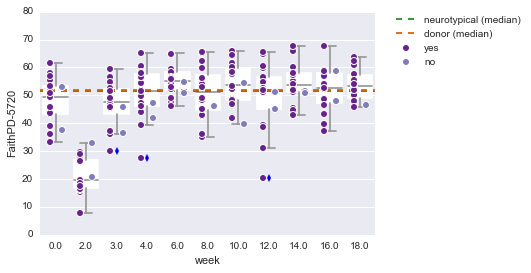

In [9]:
plot_week_data(sample_md, sample_type='swab',
               metric='FaithPD-5720', hue='Responder')

In [ ]:
plot_week_data(sample_md, sample_type='swab',
               metric='Derep-UnweightedUniFrac-PC1', hue='Responder')

In [ ]:
plot_week_data(sample_md, sample_type='swab',
               metric='Derep-WeightedUniFrac-PC1', hue='Responder')

## Change with time: stool

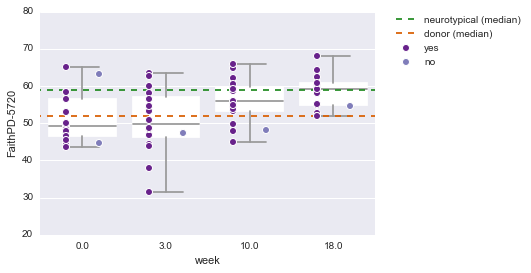

In [10]:
plot_week_data(sample_md, sample_type='stool',
               metric='FaithPD-5720', hue='Responder')

In [11]:
tabulate_week_to_week0_paired_stats(sample_md, sample_type='stool',
                                    metric='FaithPD-5720')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


,n,FaithPD-5720,t,p-value
week,,,,
0,0,NaN,NaN,NaN
3,15,-0.838176,0.014617,0.988544
10,16,6.601795,2.949345,0.009947
18,16,8.785484,5.335455,0.000083


In [12]:
tabulate_week_to_control_stats(sample_md, sample_type='stool',
                               metric='FaithPD-5720')

,n,FaithPD-5720,t,p-value
week,,,,
0,17,49.178465,-2.317556,0.026421
3,16,49.796581,-2.277617,0.029150
10,17,56.008871,-0.565709,0.575320
18,17,59.069233,0.394351,0.696193


In [ ]:
plot_week_data(sample_md, sample_type='stool',
               metric='Derep-UnweightedUniFrac-PC1', hue='Responder')

In [ ]:
plot_week_data(sample_md, sample_type='stool',
               metric='Derep-WeightedUniFrac-PC1', hue='Responder')

In [ ]:
plot_week_data(sample_md, sample_type='stool',
               metric='Bacteroides', hue='Responder')

In [ ]:
tabulate_week_to_control_stats(sample_md, sample_type='stool',
               metric='Bacteroides')

## Engraftment: Swab

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


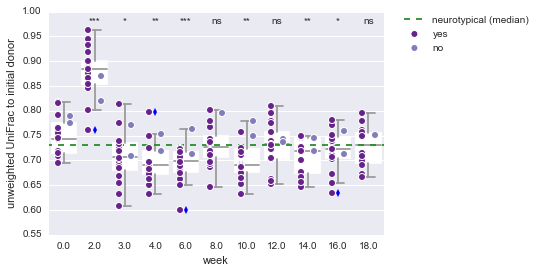

In [13]:
plot_engraftment_data(sample_md, sample_type='swab',
                      metric='unweighted UniFrac to initial donor', hue='Responder')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


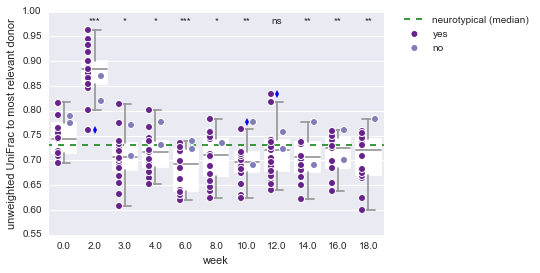

In [14]:
plot_engraftment_data(sample_md, sample_type='swab',
                      metric='unweighted UniFrac to most relevant donor', hue='Responder')

## Engraftment: stool

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


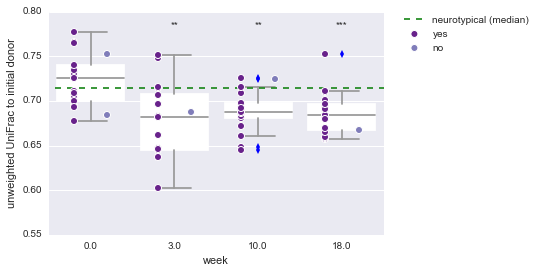

In [15]:
plot_engraftment_data(sample_md, sample_type='stool',
                      metric='unweighted UniFrac to initial donor', hue='Responder')
# tabulate_week_to_week0_paired_stats(sample_md, 'stool',
#                                    'unweighted UniFrac to initial donor')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


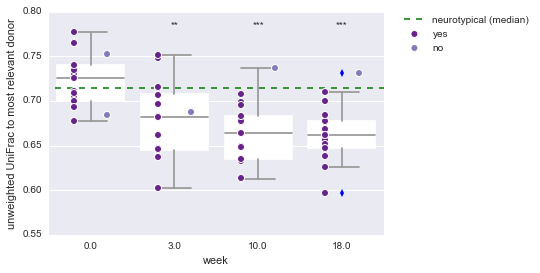

In [16]:
plot_engraftment_data(sample_md, sample_type='stool',
               metric='unweighted UniFrac to most relevant donor', hue='Responder')
# tabulate_week_to_week0_paired_stats(sample_md, 'stool',
#                                    'unweighted UniFrac to most relevant donor')

## old...

```
def engraftment_data(sample_md, dm, group_rules=None, verbose=False):
    subject_data = []
    group_sids = filter_sample_md(sample_md, group_rules).index
    donor_sids = get_donor_sids(sample_md)
    for sid in group_sids:
        subject_id = sample_md['SubjectID'][sid]
        week = sample_md['Week'][sid]
        responder = sample_md['Responder'][sid]
        faith_pd = sample_md['Dererp-PD_whole_tree_even_10000_alpha'][sid]
        unweighted_unifrac_pc1 = sample_md['Derep-UnweightedUniFrac-PC1'][sid]
        weighted_unifrac_pc1 = sample_md['Derep-WeightedUniFrac-PC1'][sid]
        
        try:
            faith_pd = float(faith_pd)
        except ValueError:
            if verbose: print('Non-floatable faith pd (%s) for %s' % (faith_pd, sid))
            faith_pd = np.nan

        try:
            unweighted_unifrac_pc1 = float(unweighted_unifrac_pc1)
        except ValueError:
            if verbose: print('Non-floatable unweighted_unifrac_pc1 (%s) for %s' % (unweighted_unifrac_pc1, sid))
            unweighted_unifrac_pc1 = np.nan

        try:
            weighted_unifrac_pc1 = float(weighted_unifrac_pc1)
        except ValueError:
            if verbose: print('Non-floatable weighted_unifrac_pc1 (%s) for %s' % (weighted_unifrac_pc1, sid))
            weighted_unifrac_pc1 = np.nan
            
        try:
            week = int(week)
        except ValueError:
            if verbose: print('Non-intable week (%s) for %s' % (week, sid))
            continue
            
        initial_donor = sample_md['BBT_Donor_ID'][sid]
        try:
            initial_donor_sid = donor_sids[initial_donor]
        except KeyError:
            if verbose: print('Unknown initial donor (%s) for %s' % (initial_donor, sid))
            continue
        initial_donor_faith_pd = sample_md['Dererp-PD_whole_tree_even_10000_alpha'][initial_donor_sid]
            
        try:
            distance_to_initial_donor = dm[initial_donor_sid, sid]
        except MissingIDError:
            if verbose: print('Missing distance for sample %s' % sid)
            distance_to_initial_donor = np.nan
            
        try:
            initial_donor_faith_pd = float(initial_donor_faith_pd)
        except ValueError:
            if verbose: print('Non-floatable Donor Faith PD (%s) for %s' % (initial_donor_faith_pd, initial_donor_sid))
            initial_donor_faith_pd = np.nan
        
        # most relevant donor is either the most recent, or the initial donor if pre-FMT
        # (which helps to evaluate initial change)
        most_relevant_donor = sample_md['MostRecentDonorID'][sid]
        if most_relevant_donor == 'pre-treatment':
            most_relevant_donor = sample_md['BBT_Donor_ID'][sid]

        try:
            most_relevant_donor_sid = donor_sids[most_relevant_donor]
        except KeyError:
            if verbose: print('Unknown most relevant donor (%s) for %s' % (most_relevant_donor, sid))
            most_relevant_donor_sid = None
        
        if most_relevant_donor_sid is not None:
            try:
                distance_to_most_relevant_donor = dm[most_relevant_donor_sid, sid]
            except MissingIDError:
                if verbose: print('Missing distance for sample %s' % sid)
                distance_to_most_relevant_donor = np.nan
        else:
            distance_to_most_relevant_donor = np.nan

        subject_data.append((subject_id, week, distance_to_initial_donor, responder, faith_pd, 
                             initial_donor_faith_pd, distance_to_most_relevant_donor, unweighted_unifrac_pc1,
                             weighted_unifrac_pc1))
    result = pd.DataFrame(subject_data, columns=['subject', 'week', 'distance to initial donor', 'responder', 
                                                 'faith pd', 'initial donor faith pd', 
                                                 'distance to most relevant donor', 'unweighted unifrac pc1',
                                                 'weighted unifrac pc1'])
    return result
```

```

def tabulate_week_to_week0_stats(df, metric):
    results = []
    df['Week'] = pd.to_numeric(df['Week'], errors='coerce')
    week0 = df[metric][df['Week'] == 0].dropna()
    week0_n = len(week0)
    weeks = sorted(set(df['Week']))
    for i in weeks:
        weeki = df[metric][df['Week'] == i].dropna()
        t, p = scipy.stats.ttest_ind(week0, weeki, equal_var=False)
        results.append((len(weeki), np.median(weeki), t, p))
    return pd.DataFrame(results, index=pd.Index(weeks, name='Week'),
                        columns=['n', 'median %s' % metric, 't (to Week 0)', 'p-value (to Week 0)'])

def tabulate_week_to_value_stats(df, metric, value):
    results = []
    weeks = sorted(set(df['week']))
    for i in weeks:
        weeki = df[metric][df['week'] == i].dropna()
        t, p = scipy.stats.ttest_1samp(weeki, popmean=value)
        results.append((len(weeki), np.median(weeki), t, p))
    return pd.DataFrame(results, index=pd.Index(weeks, name='week'),
                        columns=['n', 'median %s' % metric, 't', 'p-value'])

def plot_subject_data(df, y="distance to initial donor", baseline_y=None, hue=None):
    ## TODO: Get sharex=True to fill in missing values
    ax = sns.FacetGrid(df, col="subject", col_wrap=4,
                       hue=hue, palette=palette, sharex=False)
    if baseline_y is not None:
        x0 = np.min(df['week']) - 1
        x1 = np.max(df['week']) + 1
        for e in ax.axes:
            e.plot([x0, x1], [baseline_y, baseline_y], color=palette['donor'], linestyle='--')
    ax = ax.map(sns.pointplot, "week", y, scale=.3)
    return ax


```